# Variational Autoencoder

The variational autoencoder (VAE) aims to learn the distribution of a dataset $\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n$ given they are sampled conditioned on a latent $\mathbf{z}$ sampled as a standard Gaussian vector. Below, we show a basic implementation of a VAE that will be the basis for unsupervised generation down the road.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
from tqdm import tqdm
import torchvision
import torchvision.datasets as datasets

#for consistency, all seeds are set to 69420
seed = 69420
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

We will use the MNIST dataset for our generation experiment:

<Figure size 640x480 with 0 Axes>

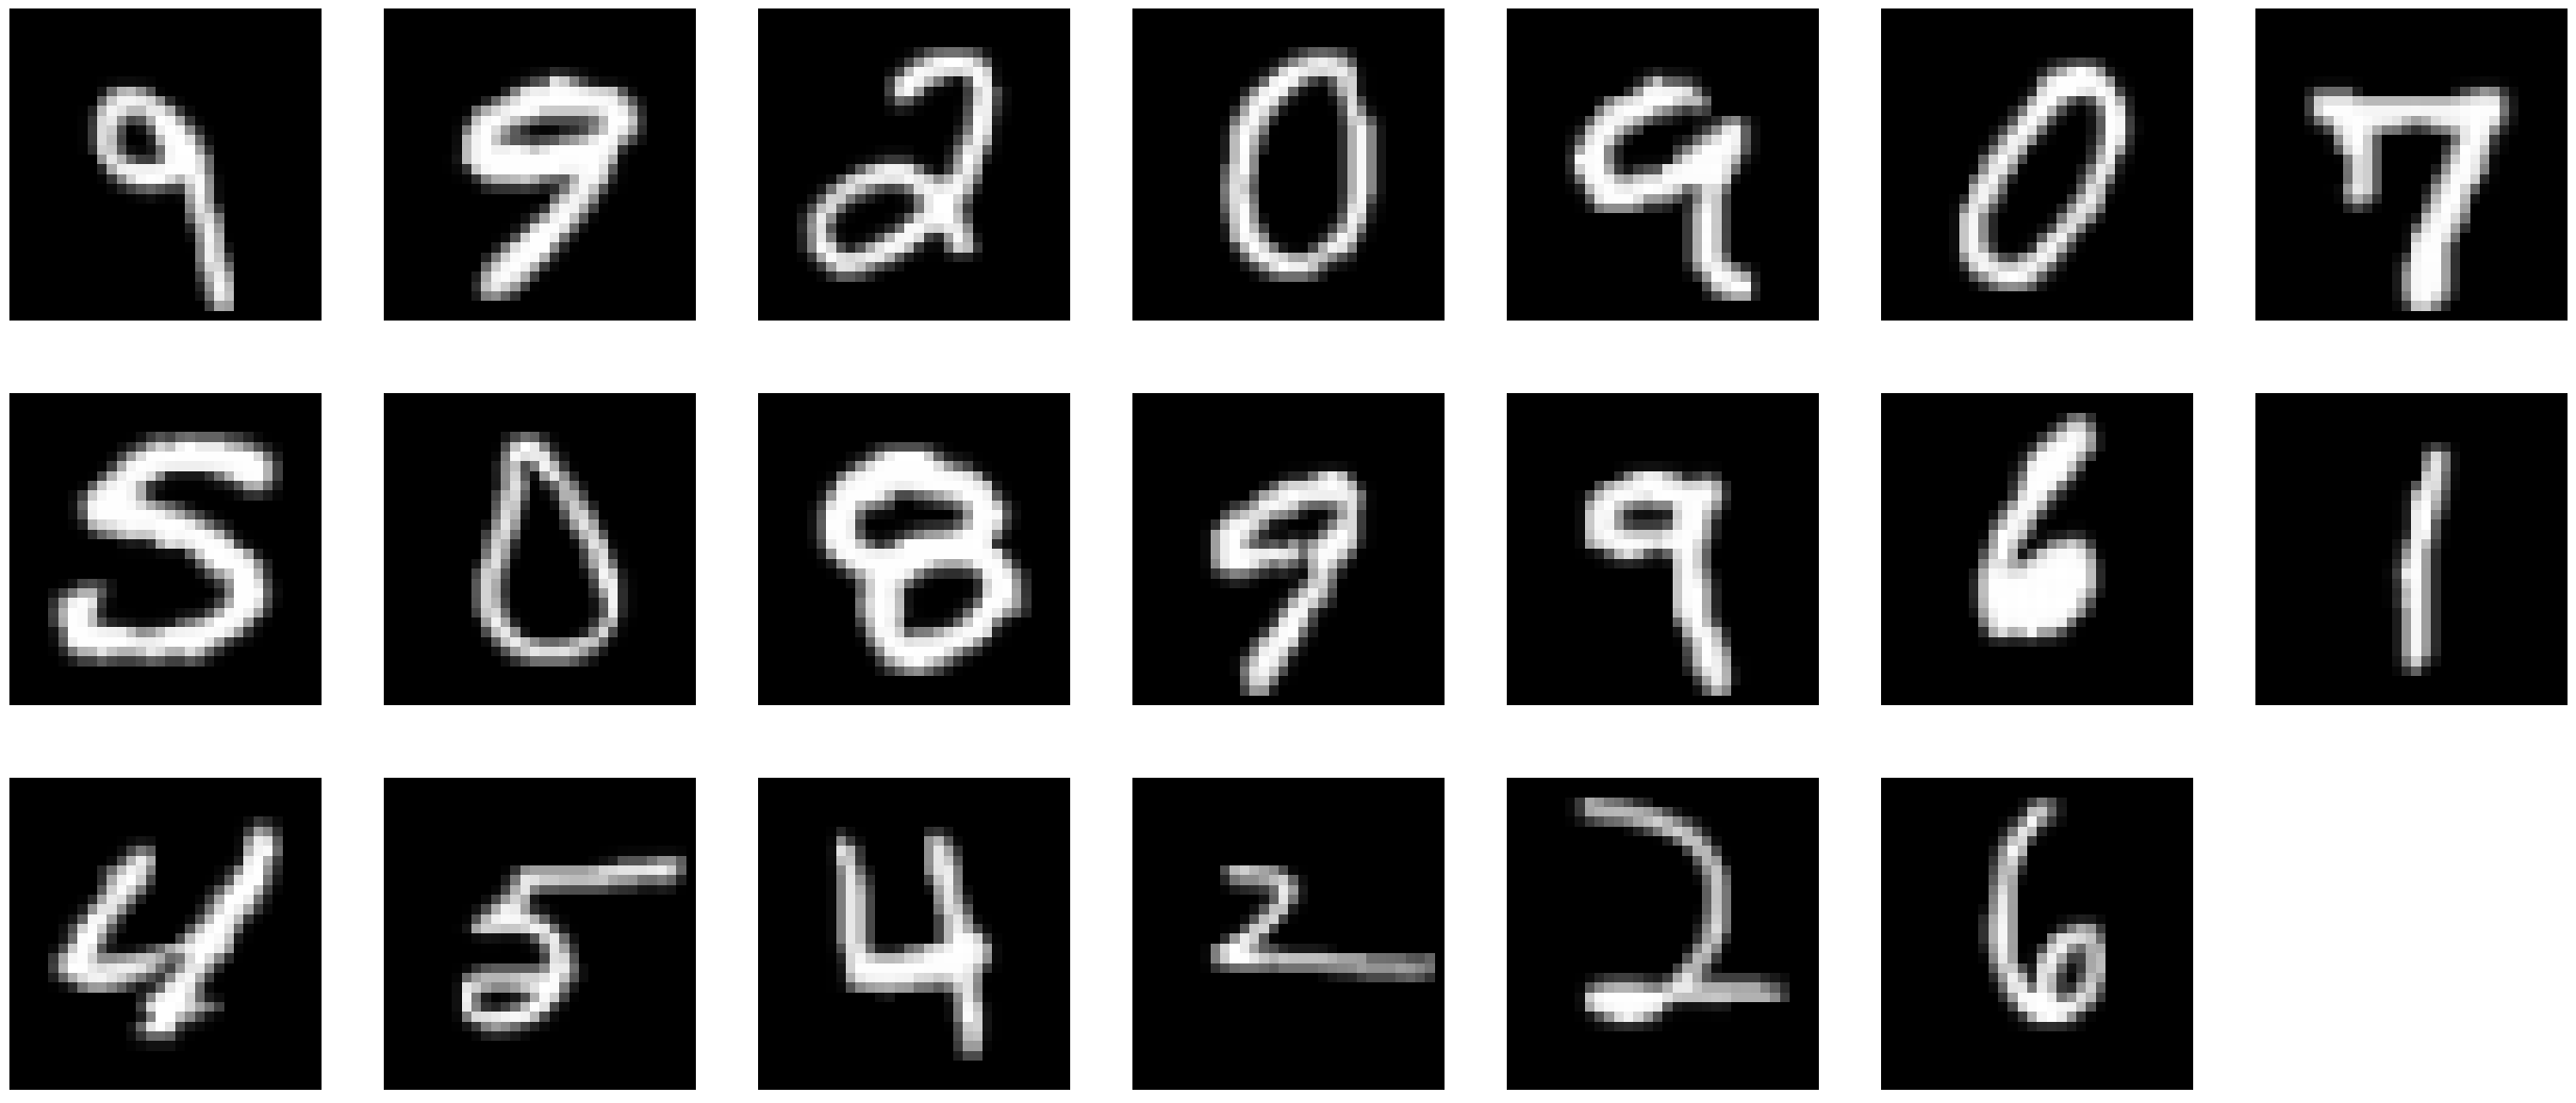

In [2]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
data_loader = torch.utils.data.DataLoader(mnist_trainset,batch_size=128,shuffle=True,num_workers=1)

plt.gray()

def plotter(images):
    f = -(-len(images)//3)
    fig,ax = plt.subplots(3,f,figsize=(5*f, 15))
    for i in range(len(images)):
        ax[i%3,i//3].imshow(images[i,0])
    for aa in ax:
        for aaa in aa:
            aaa.axis("off")
    plt.show()

for a, b in data_loader:
    plotter(a[0:20])
    break


## Encoder

The encoder aims to model $q(\mathbf{z}|\mathbf{x};\phi)$. This network produces the mean and covariance using $\mathbf{x}$, from where $\mathbf{z}$ can be sampled. The implementation uses convolutional neural network components to map $\mathbf{x}$ to the means and covariances. A trick used here is to sample the covariance from the logarithmic space to ensure positivity.

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size, img_channel):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.mu_fc = nn.Conv2d(256, latent_size, 2, 1, 0, bias=False)
        self.sigma_fc = nn.Conv2d(256, latent_size, 2, 1, 0, bias=False)
        self.kl = 0
        
    def forward(self,x,normal_generator):
        encoded = self.encoder(x)
        mu = self.mu_fc(encoded).mean([-2,-1]) #mean
        sigma = torch.exp(self.sigma_fc(encoded).mean([-2,-1])) #covariance
        z = mu + sigma*normal_generator.sample(mu.shape) #randomly sample from latent
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() # kl loss term
        return z

# Decoder

On the other hand, the decoder learns $p(\mathbf{x}|\mathbf{z};\theta)$ by reconstructing the give data $x$ using information it was given from $\mathbf{z}$. Implementation-wise, this decoder uses convolution transpose blocks to reverse the convolution of the encoder.

In [4]:
class Decoder(nn.Module):
    
    def __init__(self, latent_size, img_channel):
        
        super(Decoder, self).__init__()

        self.conv_transpose_block_1 = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv_transpose_block_5 = nn.Sequential(
            nn.ConvTranspose2d(32, img_channel, 1, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, x):
        x = self.conv_transpose_block_1(x)
        x = self.conv_transpose_block_2(x)
        x = self.conv_transpose_block_3(x)
        x = self.conv_transpose_block_4(x)
        x = self.conv_transpose_block_5(x)
        return x

## VAE training
We optimize the ELBO stochastically using the gradient descent, which boils down the minimizing the KL divergence and reconstruction terms.

In [5]:
latent_size = 128
img_ch = 1
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normal_generator = torch.distributions.Normal(torch.tensor(0).float().to(device), torch.tensor(1).float().to(device))

enc = Encoder(latent_size, img_ch).to(device)
dec = Decoder(latent_size, img_ch).to(device)

optimizer = torch.optim.Adam(list(enc.parameters())+list(dec.parameters()), lr=0.0002, betas=(0.5, 0.999))

Iteration 469/469	[Epoch 1/20]	Losses:	KL = 54.6177 	L2 = 74.9203: : 469it [00:10, 43.75it/s] 


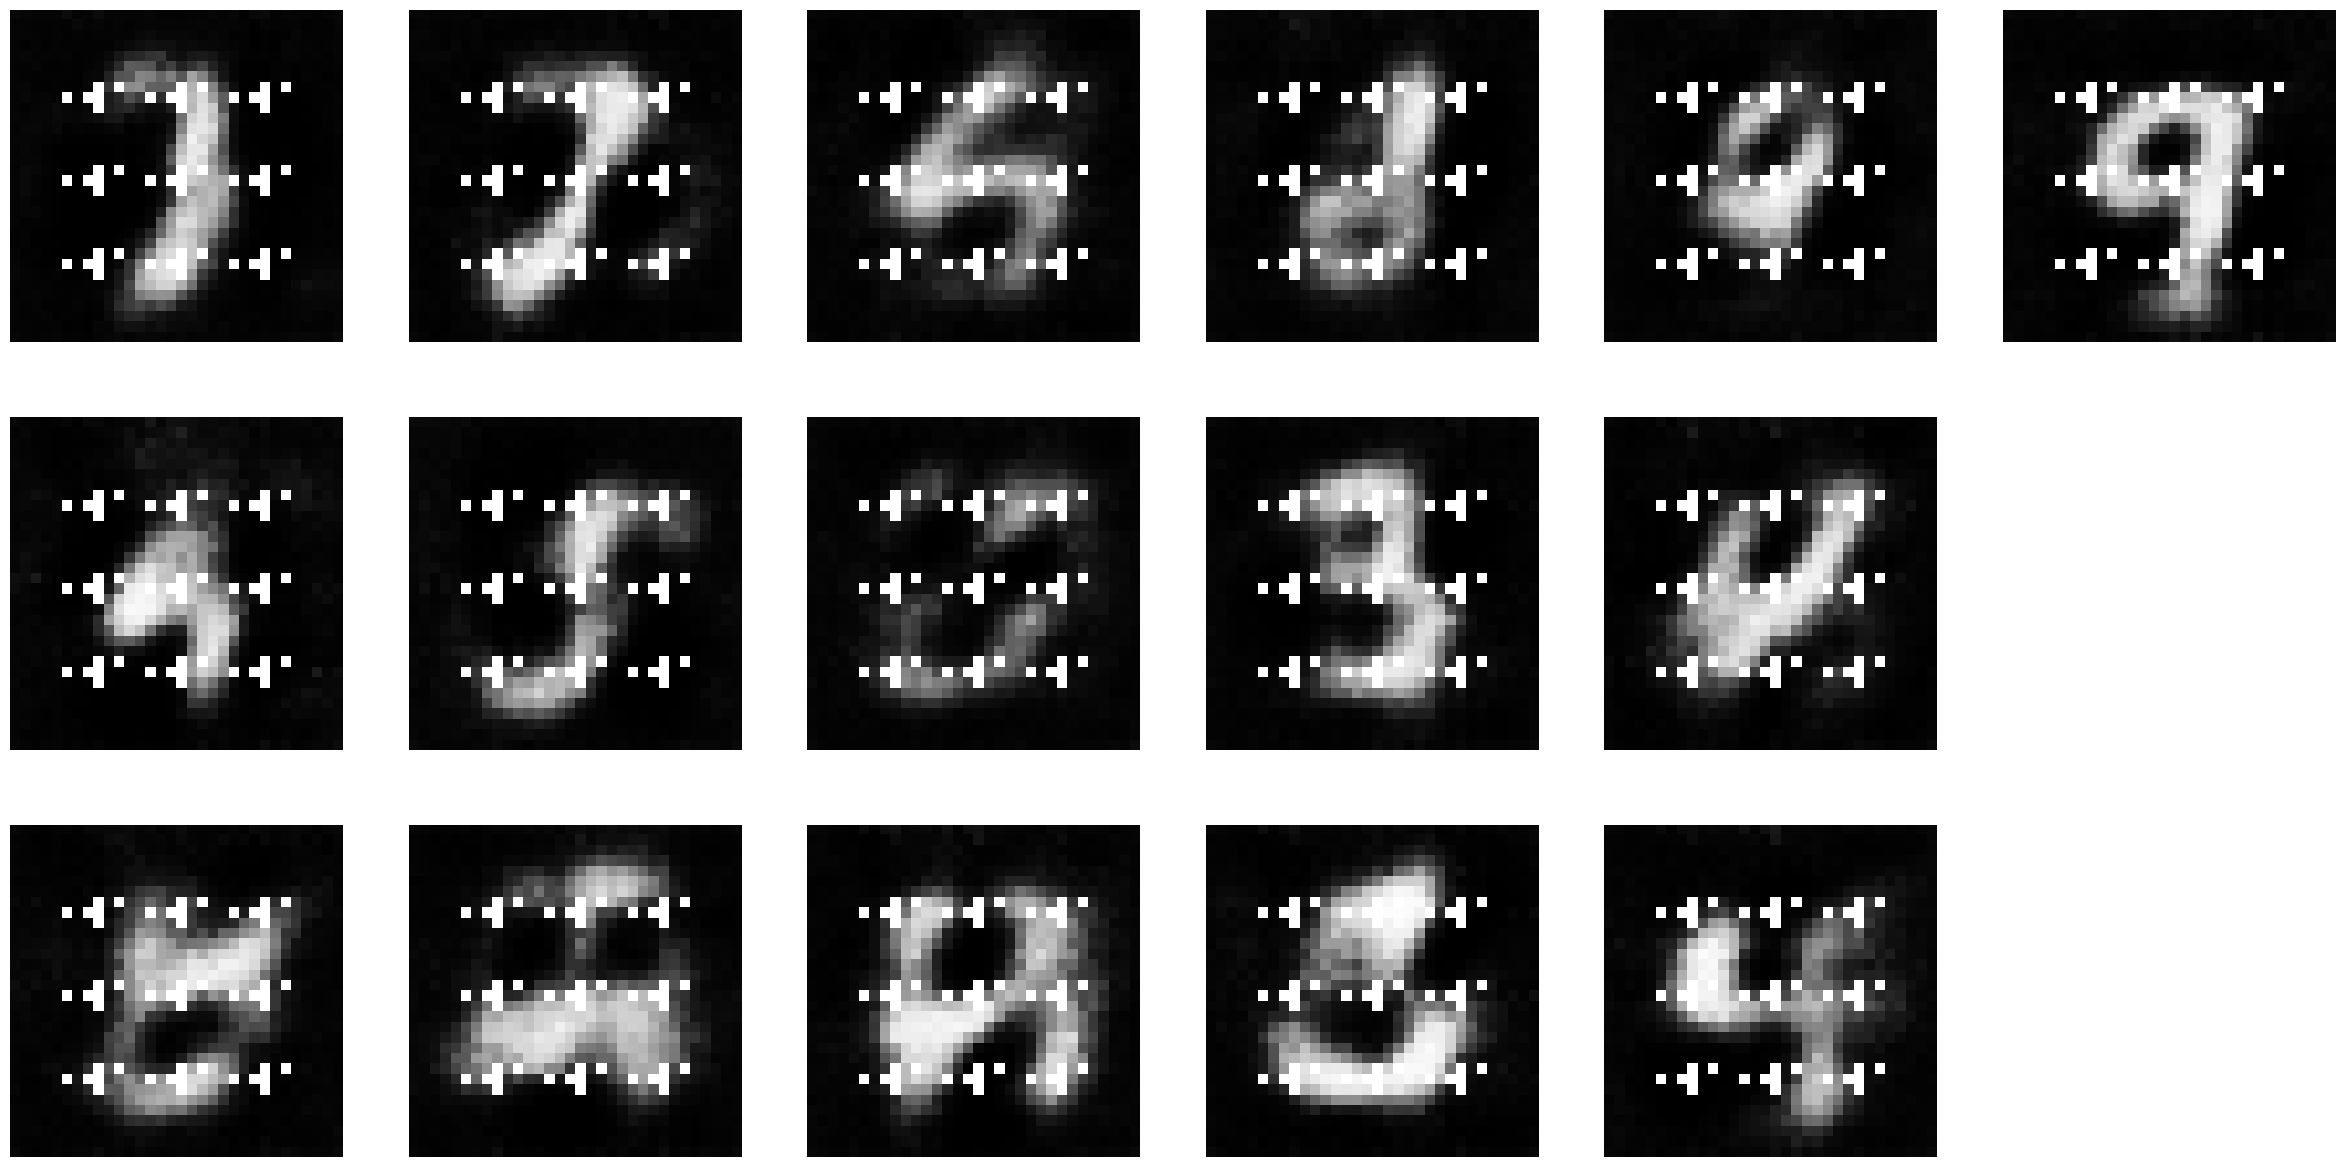

Iteration 469/469	[Epoch 2/20]	Losses:	KL = 55.1296 	L2 = 59.5712: : 469it [00:07, 63.15it/s]
Iteration 469/469	[Epoch 3/20]	Losses:	KL = 55.4779 	L2 = 57.0413: : 469it [00:08, 56.53it/s]
Iteration 469/469	[Epoch 4/20]	Losses:	KL = 55.6296 	L2 = 55.6793: : 469it [00:09, 51.96it/s]
Iteration 469/469	[Epoch 5/20]	Losses:	KL = 55.7670 	L2 = 54.7298: : 469it [00:08, 55.72it/s]


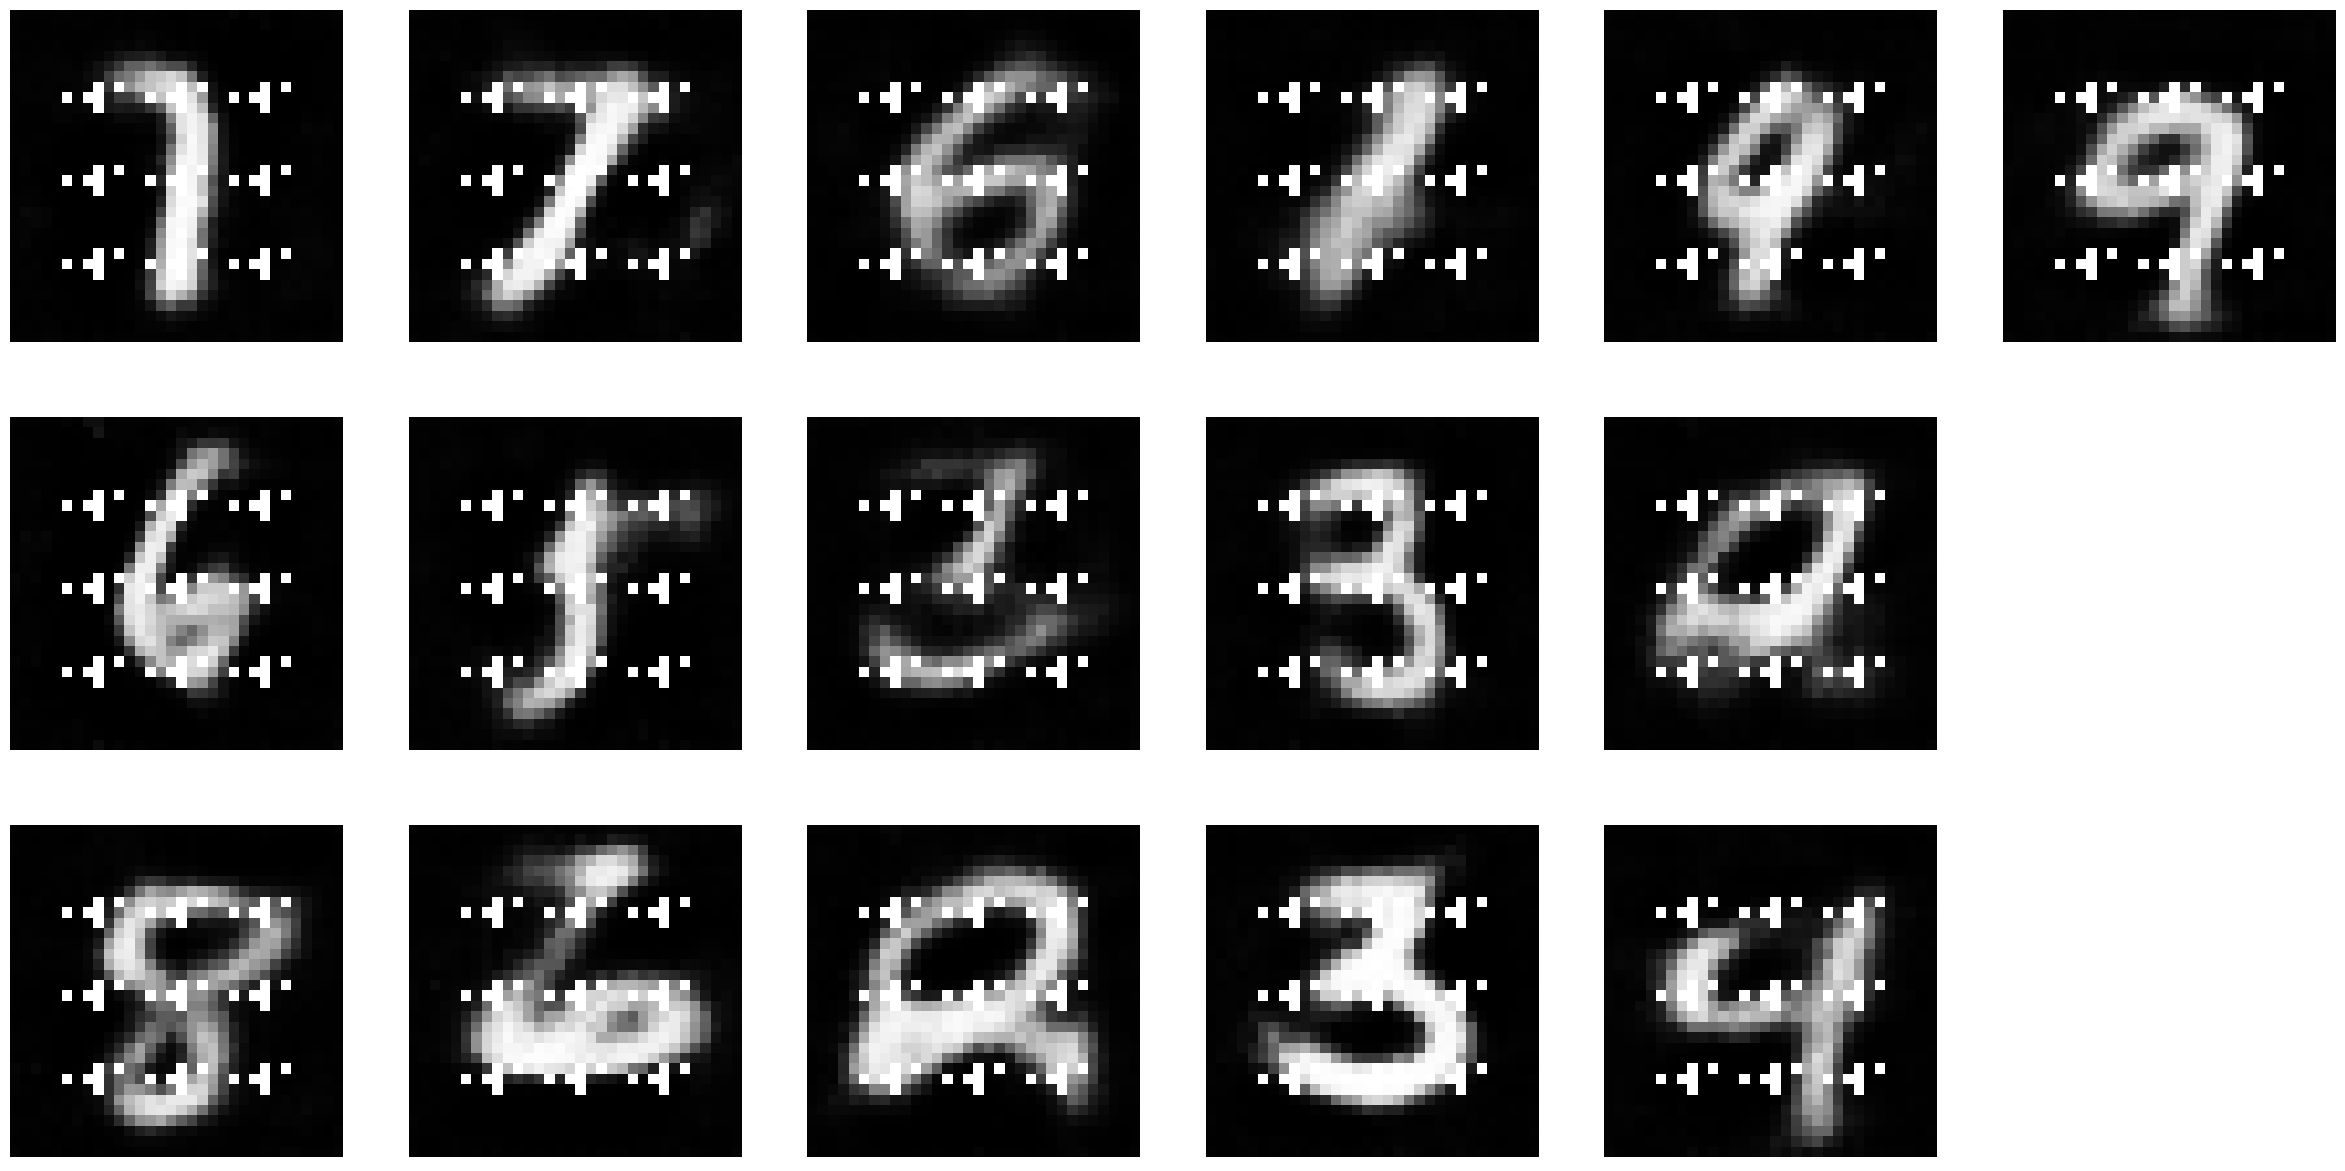

Iteration 469/469	[Epoch 6/20]	Losses:	KL = 55.8708 	L2 = 54.0338: : 469it [00:08, 56.60it/s]
Iteration 469/469	[Epoch 7/20]	Losses:	KL = 55.9657 	L2 = 53.4830: : 469it [00:09, 51.98it/s]
Iteration 469/469	[Epoch 8/20]	Losses:	KL = 56.0310 	L2 = 52.0754: : 469it [00:08, 52.75it/s]
Iteration 469/469	[Epoch 9/20]	Losses:	KL = 56.9730 	L2 = 21.1168: : 469it [00:08, 57.14it/s]


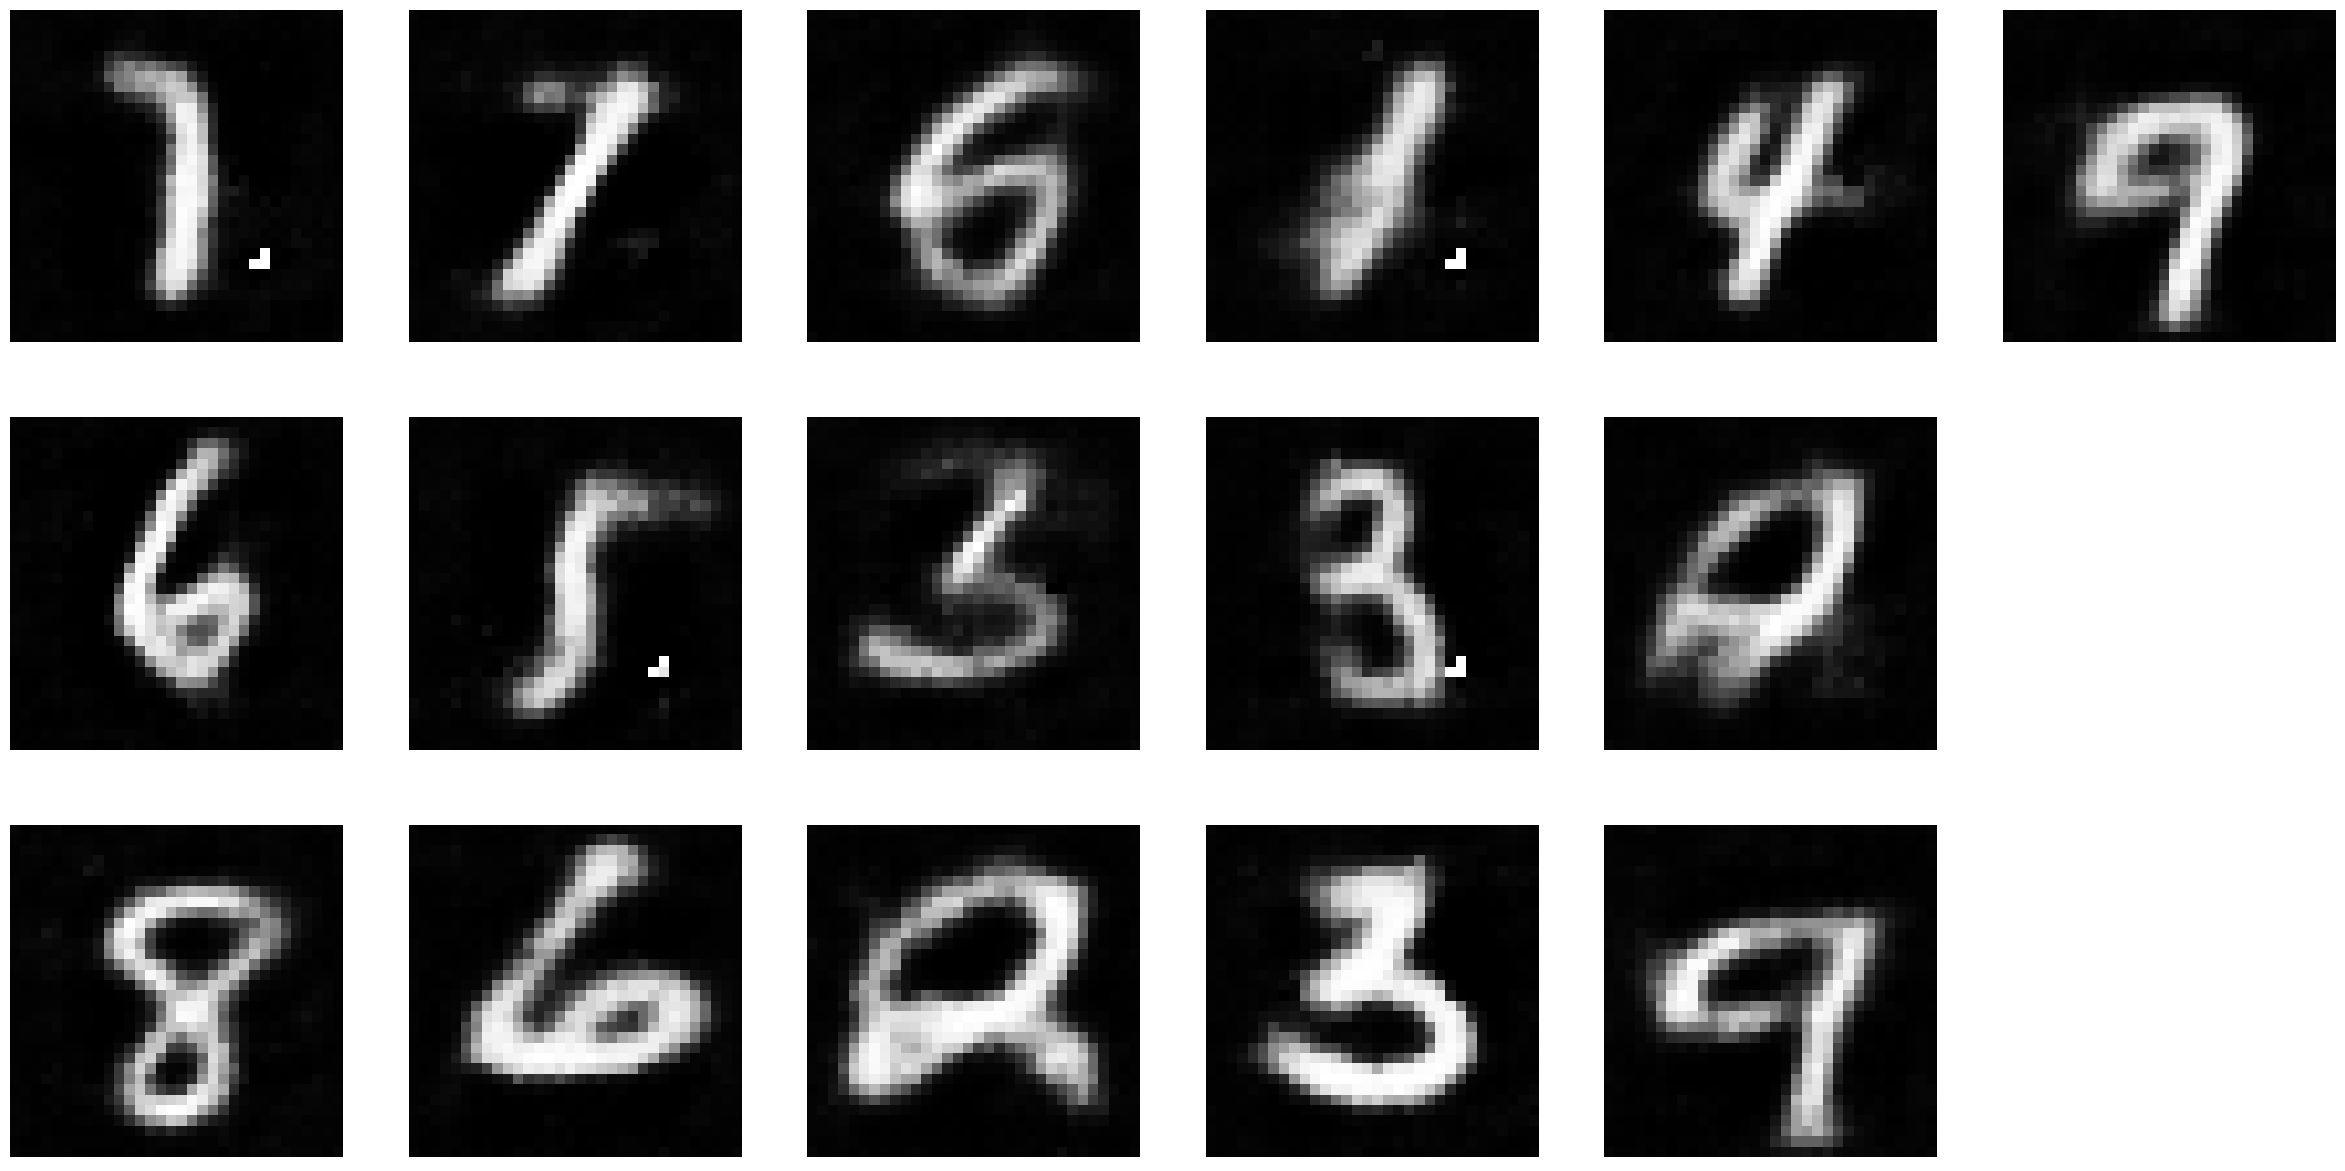

Iteration 469/469	[Epoch 10/20]	Losses:	KL = 56.9870 	L2 = 16.6223: : 469it [00:08, 56.60it/s]
Iteration 469/469	[Epoch 11/20]	Losses:	KL = 57.0317 	L2 = 15.8647: : 469it [00:09, 50.08it/s]
Iteration 469/469	[Epoch 12/20]	Losses:	KL = 57.0712 	L2 = 15.4862: : 469it [00:08, 56.54it/s]
Iteration 469/469	[Epoch 13/20]	Losses:	KL = 57.1152 	L2 = 15.2456: : 469it [00:08, 54.31it/s]


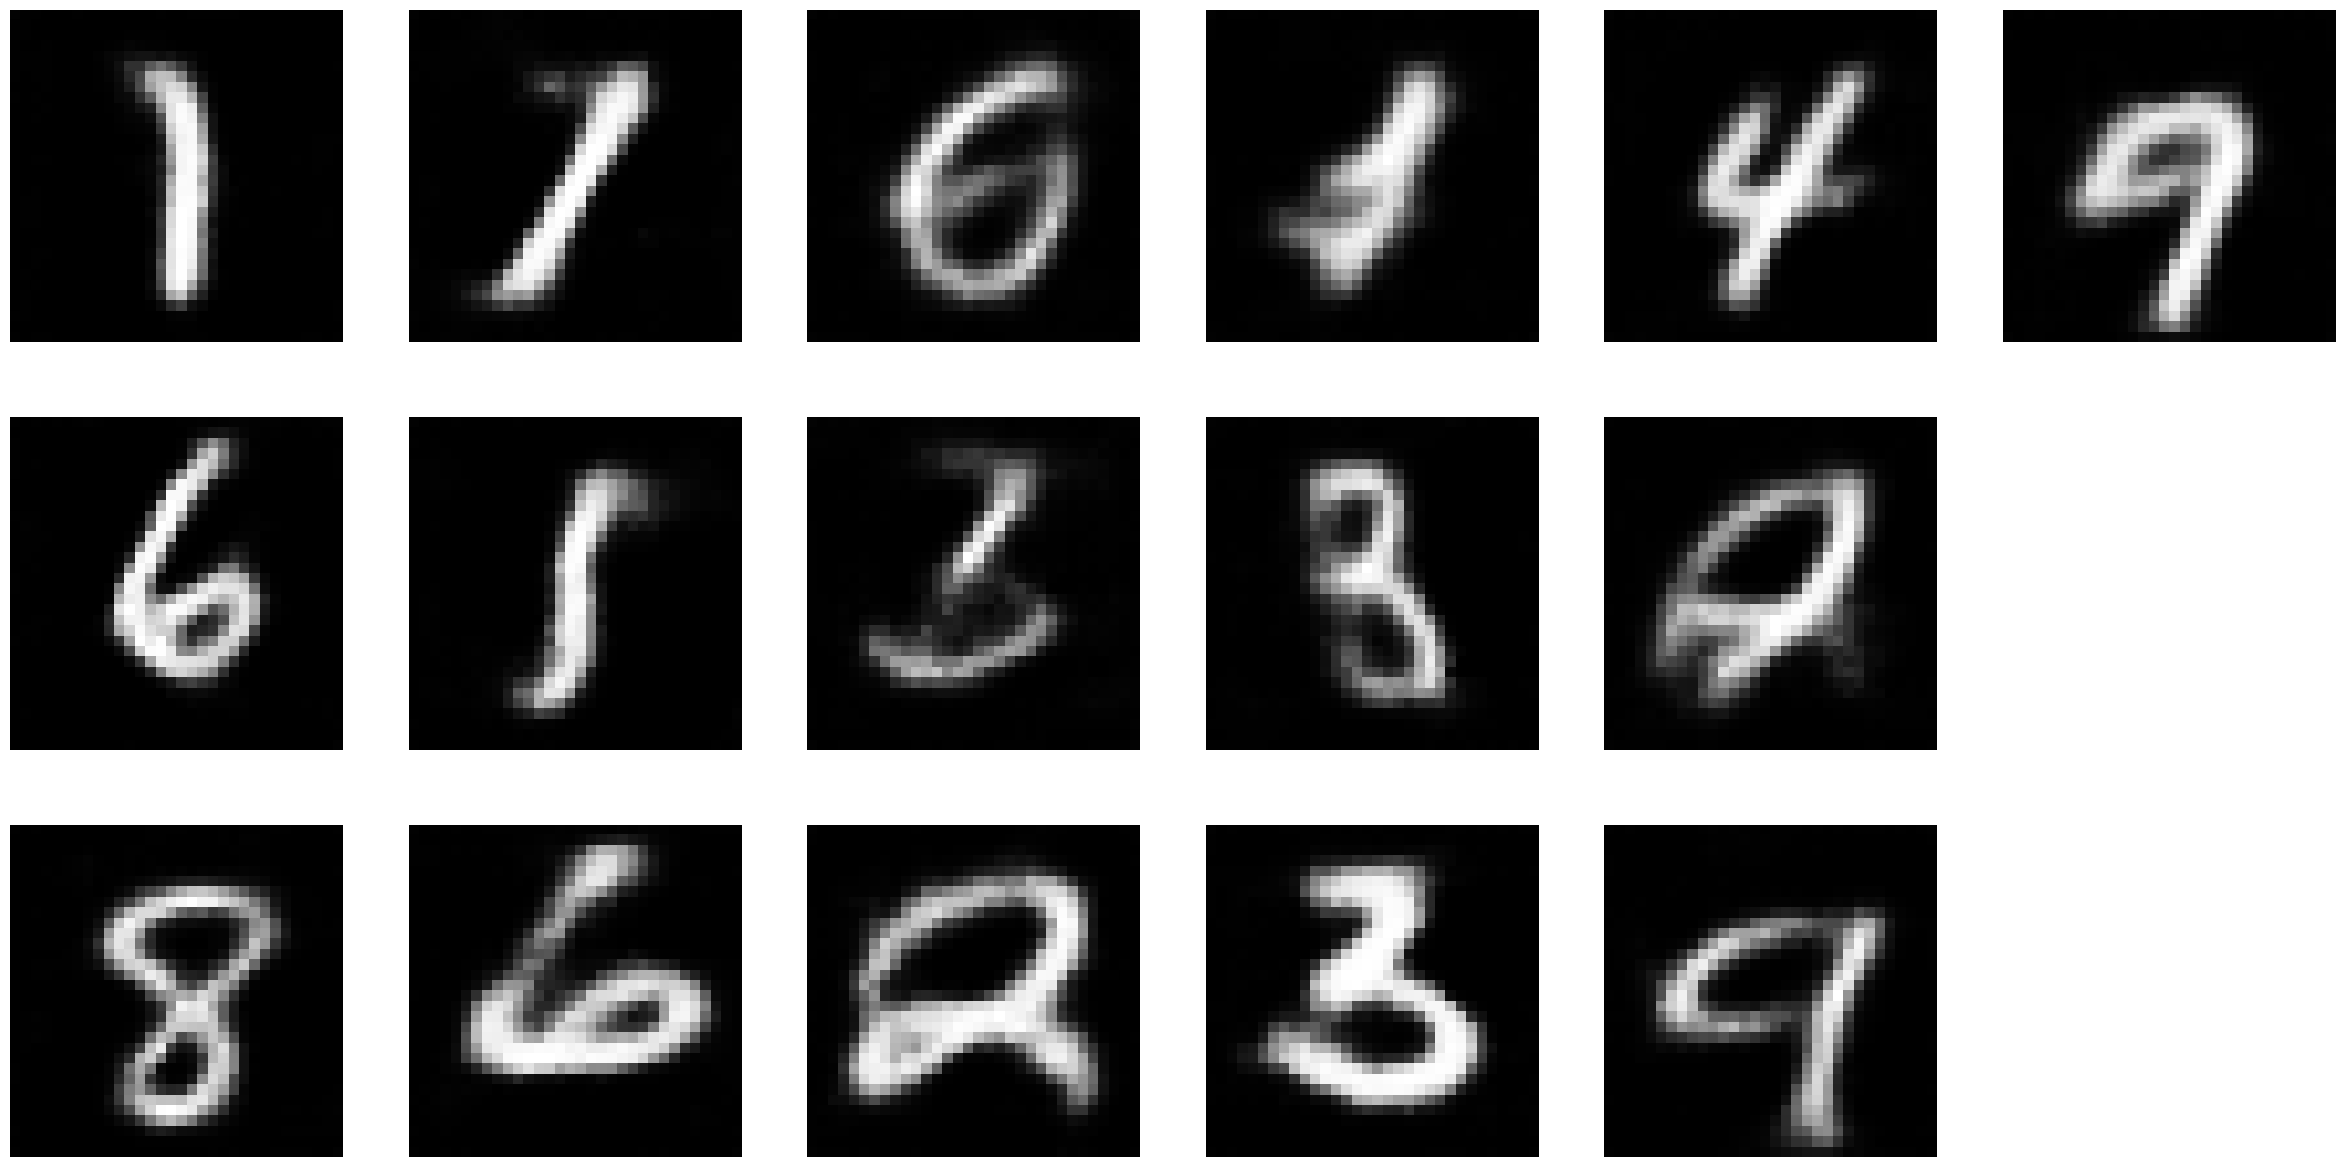

Iteration 469/469	[Epoch 14/20]	Losses:	KL = 57.1332 	L2 = 14.9883: : 469it [00:07, 59.53it/s]
Iteration 469/469	[Epoch 15/20]	Losses:	KL = 57.1782 	L2 = 14.8013: : 469it [00:08, 54.08it/s]
Iteration 469/469	[Epoch 16/20]	Losses:	KL = 57.1874 	L2 = 14.6209: : 469it [00:08, 53.45it/s]
Iteration 469/469	[Epoch 17/20]	Losses:	KL = 57.2122 	L2 = 14.4986: : 469it [00:08, 57.94it/s]


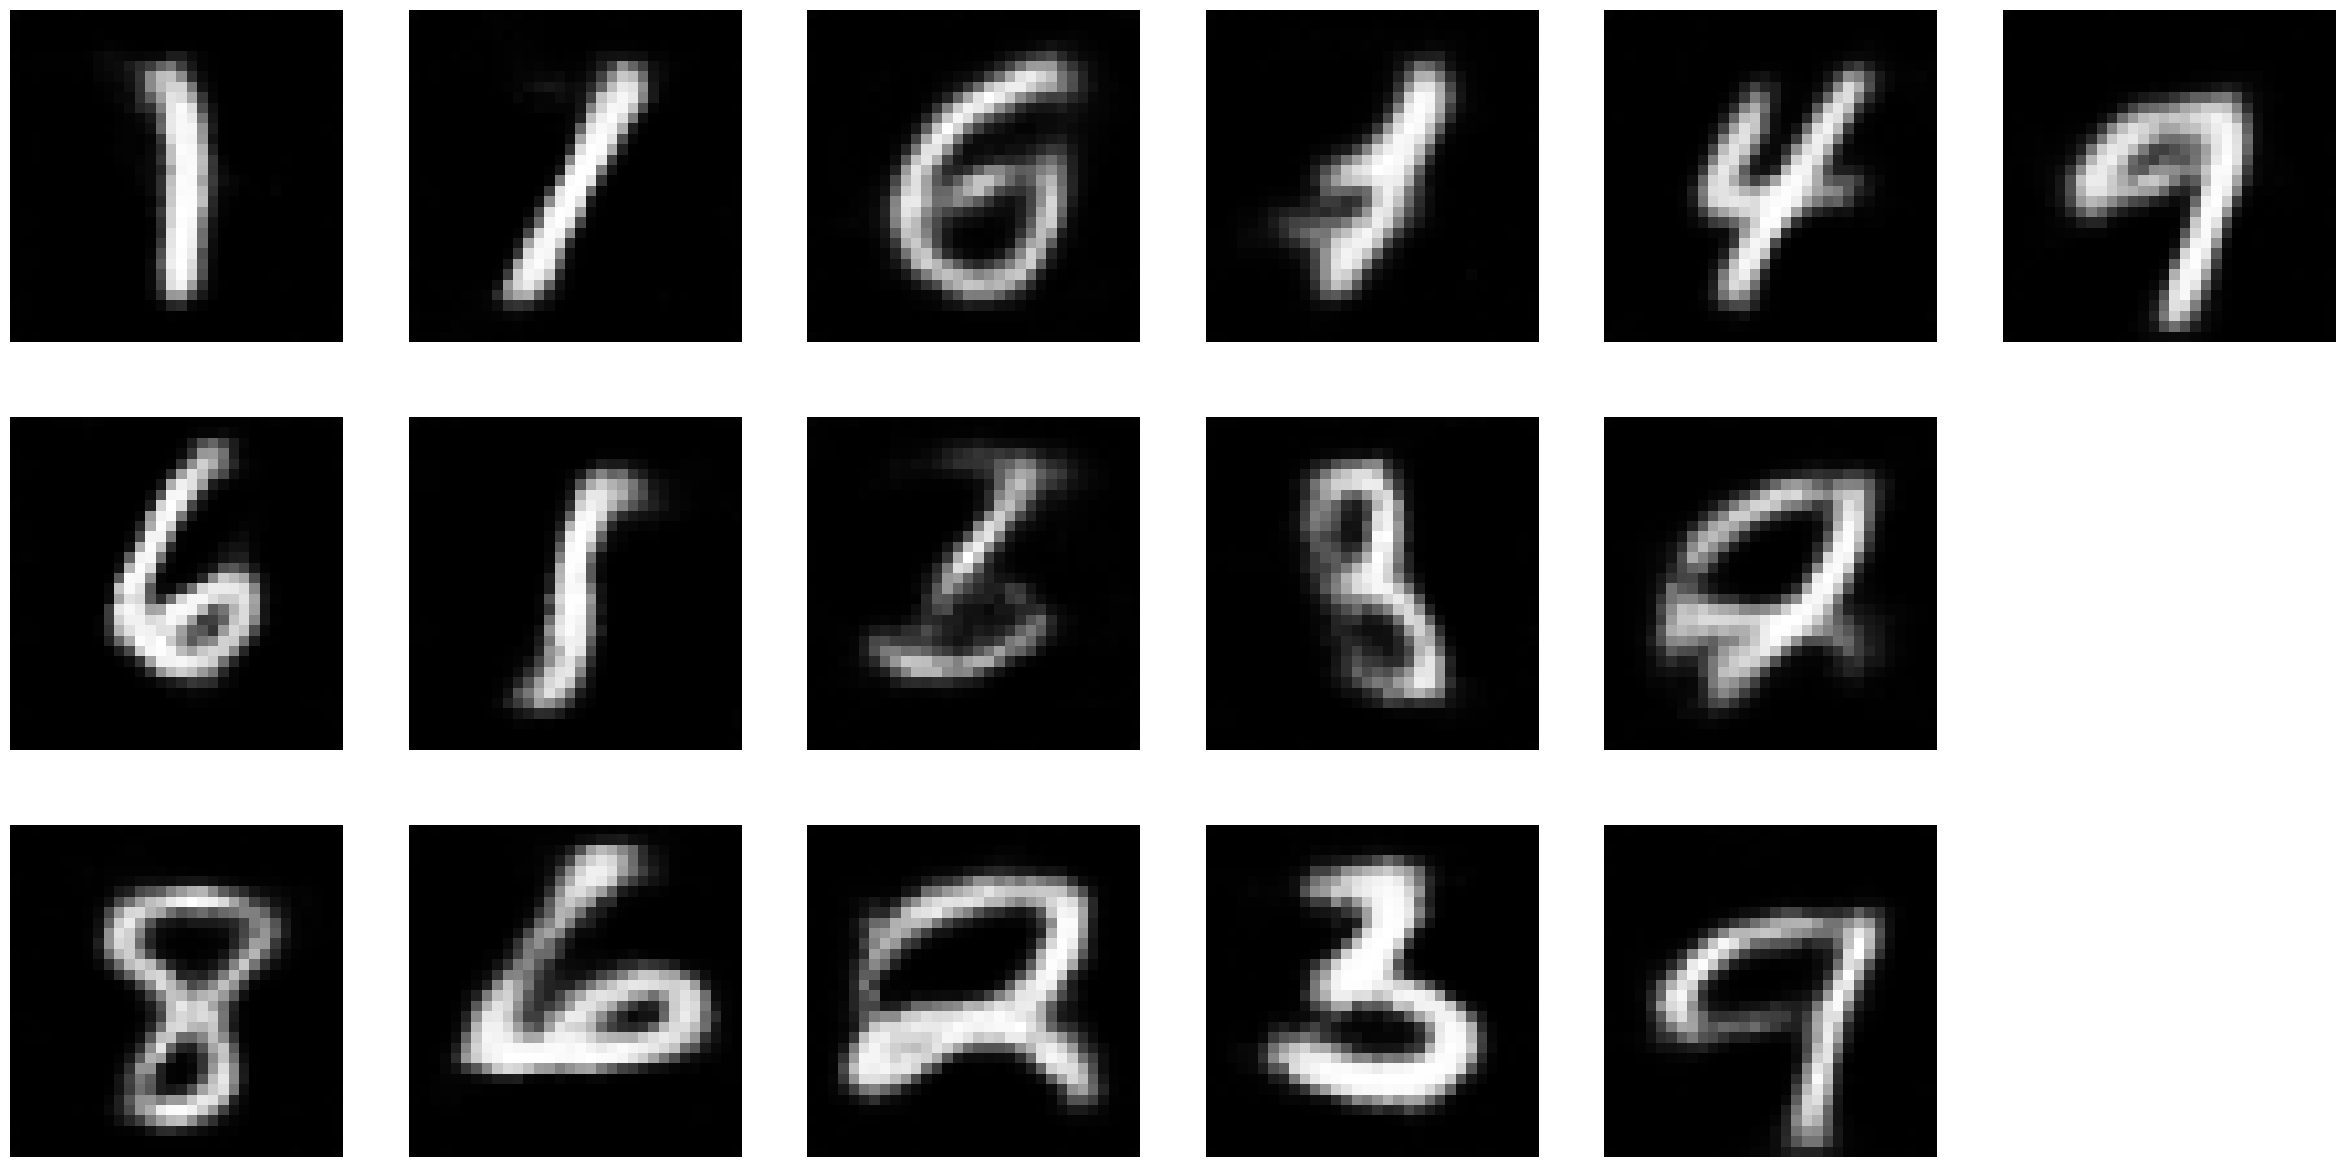

Iteration 469/469	[Epoch 18/20]	Losses:	KL = 57.2155 	L2 = 14.3469: : 469it [00:08, 56.06it/s]
Iteration 469/469	[Epoch 19/20]	Losses:	KL = 57.2327 	L2 = 14.2015: : 469it [00:08, 54.61it/s]
Iteration 469/469	[Epoch 20/20]	Losses:	KL = 57.2461 	L2 = 14.0969: : 469it [00:07, 60.74it/s]


In [6]:
visualize_noise = torch.randn(16, latent_size, 1, 1).float().to(device)

for epoch in range(num_epochs):
    pbar = tqdm(enumerate(data_loader))
    enc.train()
    dec.train()
    count = 0
    kl_sum = 0
    l2_sum = 0
    for i, (data, _) in pbar:
        optimizer.zero_grad()
        x = data.to(device)
        b = x.shape[0]
        z = enc(x, normal_generator)
        kl_loss = enc.kl
        reconstructed = dec(z.reshape(b,latent_size,1,1))
        l2_loss = ((reconstructed - x)**2).sum()
        vae_loss = kl_loss + l2_loss
        vae_loss.backward()
        optimizer.step()
        
        count += b
        kl_sum += kl_loss.item()
        l2_sum += l2_loss.item()
        
        kl_loss_show = '{:.4f}'.format(kl_sum/count)
        l2_loss_show = '{:.4f}'.format(l2_sum/count)
        pbar.set_description(f'Iteration {i+1}/{len(data_loader)}\t[Epoch {epoch+1}/{num_epochs}]\tLosses:\tKL = {kl_loss_show} \tL2 = {l2_loss_show}')
    
    # visualize every 4 epochs
    if epoch%4==0:
        with torch.no_grad():
            dec.eval()
            pred = dec(visualize_noise.to(device).float())
            plotter(pred.cpu())

## Inference

Sampling random noise from $\mathcal{N}(\mathbf{0},\mathbf{I})$, we are able to use the decoder to generate its corresponding $\mathbf{x}$:

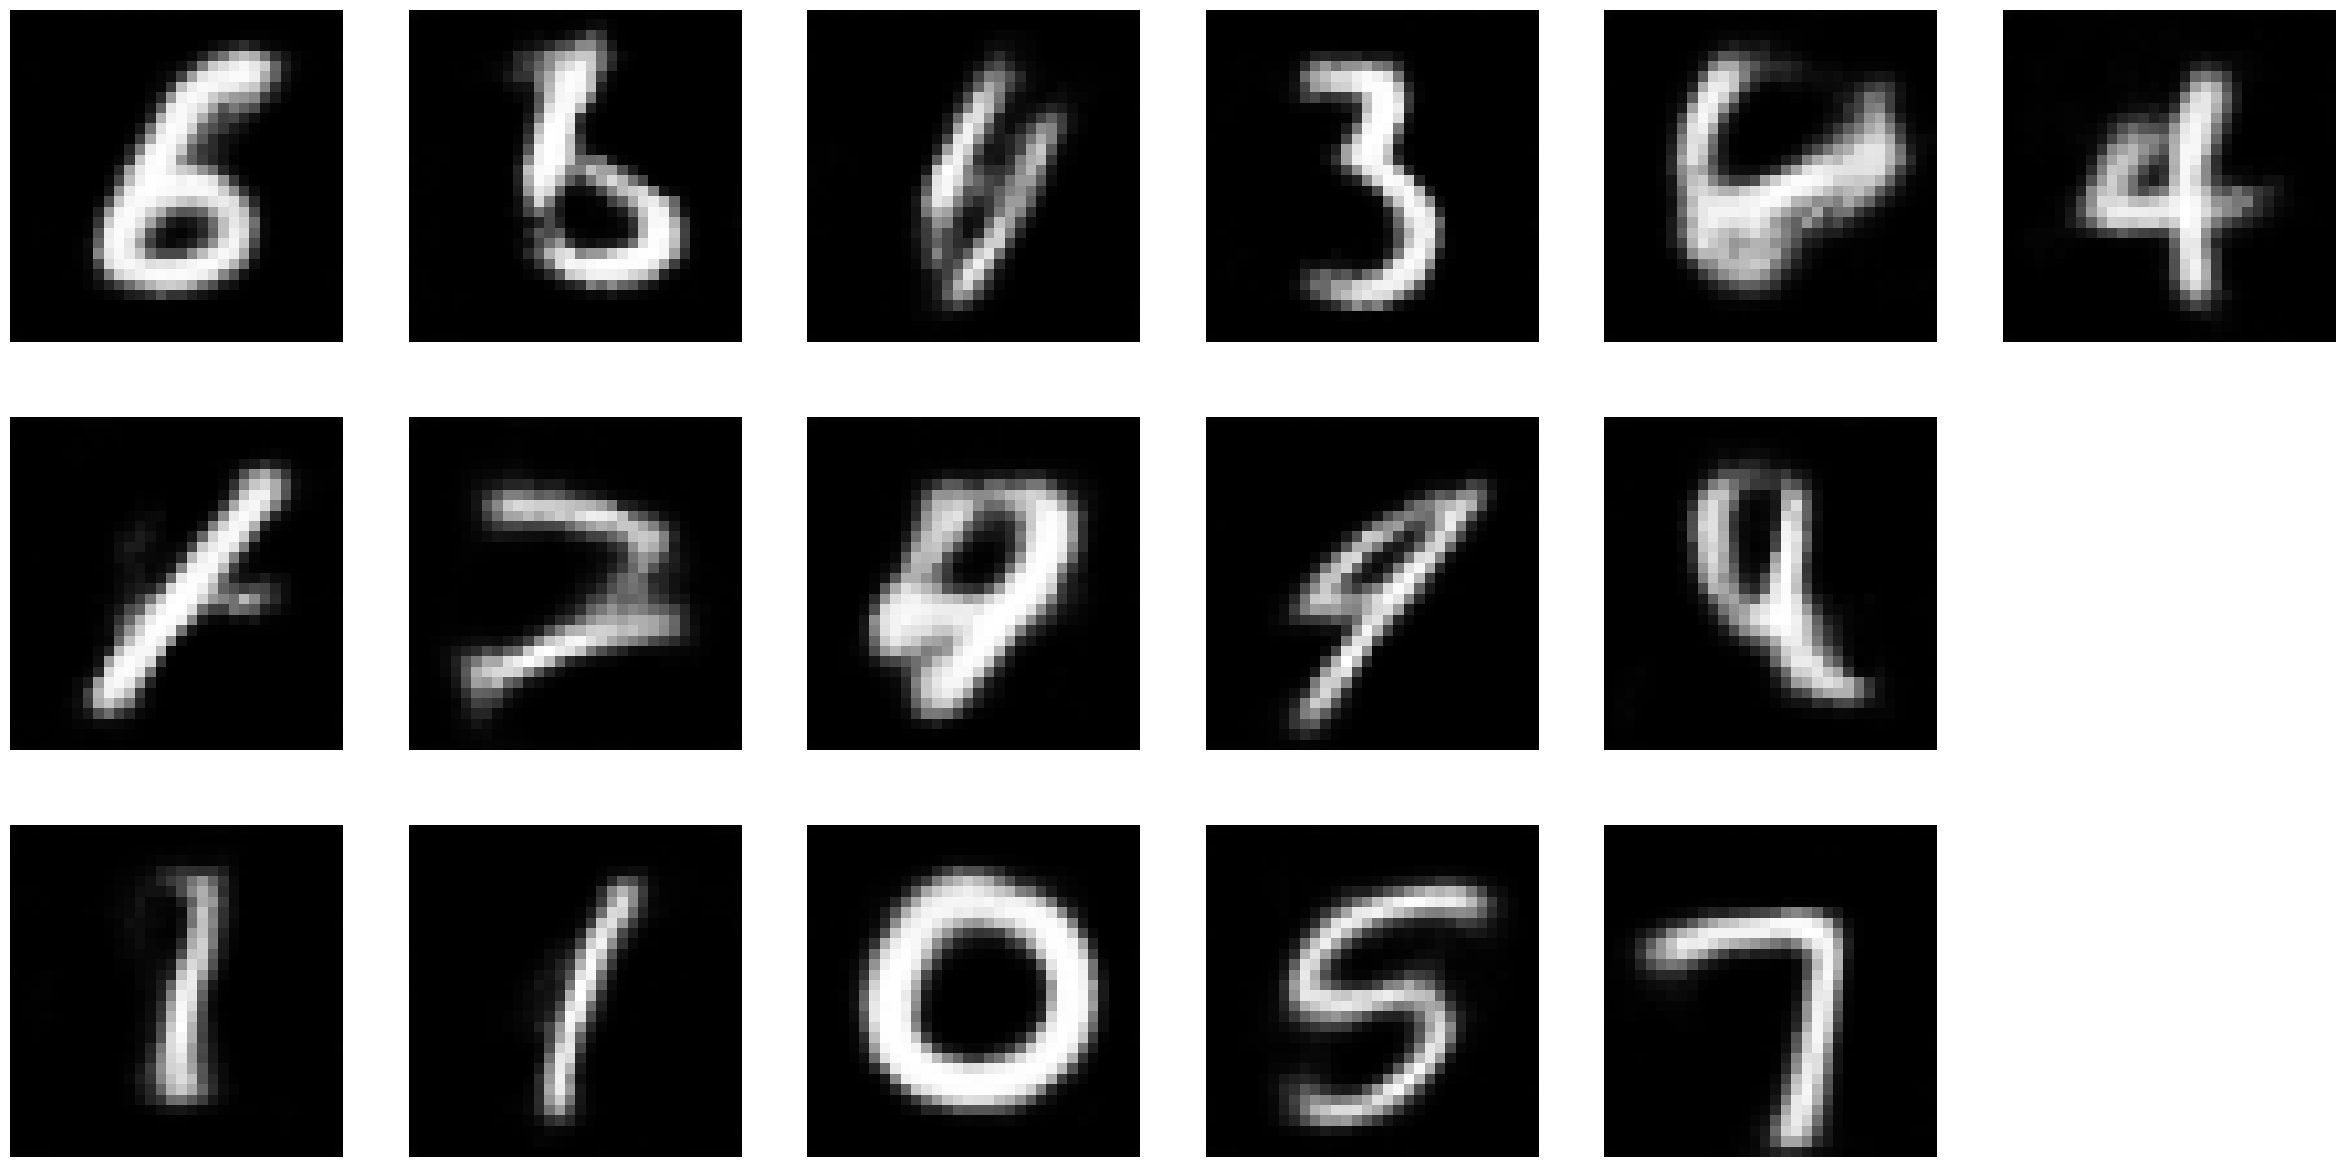

In [7]:
noise = torch.randn(16, latent_size, 1, 1).float().to(device)

with torch.no_grad():
    dec.eval()
    pred = dec(noise.to(device).float())
    plotter(pred.cpu())